In [1]:
import math
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from pyswarm import pso

In [2]:
#### functions to transform 1-array into triangular inf matrix  and vice versa ####

def i2j_to_k(i, j):
    return i*(i-1)/2 + j


def k_to_i2j(k):
    i = int((1+math.sqrt(1+8*k))/2)
    j = int(k - i*(i-1)/2)
    return (i,j)
    

def d1_2_mat(d):
    l = len(d)
    (n, _) = k_to_i2j(l)
    #print(n)
    mat = np.zeros([n,n])
    for k in range(l):
            (i,j) = k_to_i2j(k)
            mat[i,j] = d[k]
            mat[j,i] = -d[k]
    return mat


def mat_2_d1(mat):
    
    (n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    liste = []
    for k in range(k_max):
        (i,j) = k_to_i2j(k)
        liste.append(mat[k_to_i2j(k)])
        
    return np.array(liste)


def d1_2_mat_list(d, n_Item):
    
    item_list = np.reshape(np.array(d), (n_Item, -1))
    l = len(item_list[0])
    
    (n, _) = k_to_i2j(l)

    mat = np.zeros([n_Item,n,n])
    
    for it in range(n_Item):

        for k in range(l):
                (i,j) = k_to_i2j(k)
                mat[it,i,j] = item_list[it,k]
                mat[it,j,i] = -item_list[it,k]
    return mat


def mat_2_d1_list(mat):
    
    liste_totale = []
    (n_item, n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    for it in range(n_item):
        liste = []
        for k in range(k_max):
            (i,j) = k_to_i2j(k)
            liste.append(mat[it,i,j])
            
        liste_totale+= liste

    return np.array(liste_totale)    

In [3]:
def detection_cooperation_old(env, id_agent_source, last_offer): #ratio other agent gave / what I could give
    n_agents = env.n_agents
    agent = env.agents[id_agent_source]
    history = env.transactions_history_numpy
    if len(history) < 2:
        return np.zeros(n_agents)
    else:
        last_trans = history[-2].sum(1) #what each agent gave
        #last_offer = agent.last_offers[-1]
        my_offer_max = np.sum(np.maximum(last_offer,0))
        
        #print("last_trans", last_trans)
        
        coop_degrees = np.clip(last_trans/my_offer_max,0,1)
    
        return coop_degrees

In [4]:
def detection_cooperation(env, id_agent_source, last_offer): #ratio other agent gave ME * (N_agent-1) / what I could give
    n_agents = env.n_agents
    agent = env.agents[id_agent_source]
    history = env.transactions_history_numpy
    if len(history) < 2:
        return np.zeros(n_agents)
    else:        
        # history[-1] is the history location for the current step
        # history[-2] is the history location for the previous step
        last_trans = history[-2][:, id_agent_source] * (n_agents - 1) #what each agent gave
        my_offer_max = np.sum(np.maximum(last_offer, 0))
        
        #print("last_trans", last_trans)
        #print("my_offer_max", my_offer_max)
        
        coop_degrees = np.clip(last_trans/my_offer_max, 0, 1)
    
        return coop_degrees

In [5]:
def TFT(alpha, r, beta=0):
    def function(old_coop_degrees, detected_coop_degrees, r):
        delta = detected_coop_degrees - old_coop_degrees
        r = np.maximum(r + beta*delta, 0)
        output = alpha*old_coop_degrees + (1-alpha)*(r + (1-r)*detected_coop_degrees)        
        return output, r
        
    return function, r

In [6]:
class Agent:
    def __init__(self, id_agent, n_agents, n_items, neg_algo=0):
        self.n_agents = n_agents
        self.n_items = n_items
        self.id_agent = id_agent
        self.old_coop_degrees = np.zeros(self.n_agents)
        self.ut_function = []
        self.last_offers = []
        tft_algo, r = neg_algo
        self.negociation_algo =  tft_algo
        self.r = r * np.ones(self.n_agents)
        
    def coop_detection(self, env):
        n_agents = env.n_agents
        id_agent_source = self.id_agent
        if len(self.last_offers) == 0:
            # no last offer
            return np.zeros(n_agents)            
        else:
            # presence last offer(s)
            last_offer = self.last_offers[-1]
            output = detection_cooperation(env, id_agent_source, last_offer)
            return output 
        
    def offer(self, env):
        tran= env.optimize_localy(self.id_agent)
        self.last_offers.append(tran)
        return tran
    
    def negociation(self, detected_coop_degrees):
        output, r_new = self.negociation_algo(self.old_coop_degrees, detected_coop_degrees, self.r)
        self.r = r_new
        self.old_coop_degrees = output
        return output

In [7]:
class Environment:
    def __init__(self, n_agents, n_items, list_agents = []):
        self.n_agents = n_agents
        self.agents = list_agents
        self.n_items = n_items
        self.t = 0 #step 
        self.state = np.zeros([n_agents, n_items])
        self.states_history = [] #history of states
        self.transactions_history = []
        self.transactions_history_numpy = []
        
        self.optimal_SW = 0 #optimal social welfare 
        self.hist_SW = [] #evolution of social welfare
        self.hist_ut_agents = [[] for _ in range(self.n_agents)] #evolution of utilities of agents 
        
        self.hist_coop_degrees = [] #evolution of cooperation degrees
        
        
    def init_state(self, state):
        s = np.copy(state)
        self.state = s
        self.t = 0
        
    def next_round(self):
        self.t += 1
        self.transactions_history.append([])
        self.transactions_history_numpy.append(np.zeros([env.n_agents, env.n_agents]))
        
    def replace_agents(self, list_agents):
        self.agents = list_agents
        
    def clip_state(self, lb, ub):
        self.state = np.clip(self.state, lb, ub)
    
    def random_init(self, mean=0, std=1):
        self.state = np.random.normal(mean, std, size = [self.n_agents, self.n_items])
        
    def transaction(self, id_agent_source, id_agent_target, id_item, quantity):
        self.state[id_agent_target, id_item] += quantity
        self.state[id_agent_source, id_item] -= quantity
        
        self.transactions_history[-1].append((env.t, id_agent_source, id_agent_target, id_item, quantity))
        
        #update quantities shared between agents (independently of items)
        self.transactions_history_numpy[-1][id_agent_source, id_agent_target] += quantity
        
        
        
    def add_transactions_np(self, state, transactions):
        #state : array nA x nI
        #transactions : array nI x nA x nA

        (nA, nI) = np.shape(state)
        new_s = state.copy()
        for item in range(nI):
            for agent in range(nA):
                new_s[agent, item] -= transactions[item, agent, : ].sum()

        return new_s
    
    def add_transactions_var(self, state, trans_var):
        #state : array nA x nI
        #trans_var : variable for optimisation, list
        transactions = d1_2_mat_list(trans_var, self.n_items)
        return self.add_transactions_np(state, transactions)
    

    def global_utility(self, state, lb =-2.0, ub = 100.0):
        s = np.copy(state)
        s = np.clip(s, lb, ub)
        return -np.log(s+2+1e-8).sum()
    
    def local_utility(self, state, id_agent):
        s = np.copy(state)
        s = s[id_agent,:]
        s = np.clip(s, -2, 100)
        return -np.log(s+2+1e-8).sum()
    
    def optimize_localy(self, id_agent, lb = -4, ub = 4, min_cons = -1):
        (nA, nI) = self.n_agents, self.n_items
        size_var = nI #size of variable 
        lb_list = lb*np.ones(size_var) #lower bounds
        ub_list = ub*np.ones(size_var) #upper bounds
        
        s_tmp = np.copy(self.state)
        
        def f_opt(dx): #utility function for pso
            s = np.copy(s_tmp)
            s[id_agent, :] += dx
            return self.local_utility(s, id_agent) + 0.01 * np.linalg.norm(dx)
            
        def constraint(dx):
            s = np.copy(s_tmp)
            s[id_agent, :] += dx       
            s = s[id_agent]        
            const_out1 = s-min_cons
            const_out2 = np.array([-dx.sum()])
            const_out = np.concatenate((const_out1,const_out2))

            return const_out
        
        xopt, fopt = pso(f_opt, f_ieqcons= constraint, lb=lb_list, ub=ub_list, maxiter=200, swarmsize=200)
        
        return(xopt)
    
    
    def optimize_globally(self, lb = -2.0, ub = 2.0):
        (nA, nI) = self.n_agents, self.n_items
        k_max = nI * ( int((nA-1)*(nA-2)/2 + nA-1)  )
        d_var = np.zeros(k_max)
        lb_list = lb*np.ones(k_max)
        ub_list = ub*np.ones(k_max)
        
        s = self.state.copy()
        
        def f_opt(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            fusion_items = trans_var_np.sum(0)
            received_agents = fusion_items.sum(1)
            
            return self.global_utility(new_s_tmp) + 0.1*np.linalg.norm(received_agents) + 0.1 * np.linalg.norm(dx) 
    
        def constraint(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            const_out = new_s_tmp - min_cons
            #const_out2 = np.array([-dx.sum()])
            #const_out = np.concatenate((const_out1,const_out2))

            return const_out
    
        xopt, fopt = pso(f_opt, lb_list, ub_list, maxiter=300, swarmsize=300)
        
        transactions = d1_2_mat_list(xopt, self.n_items)
        new_s = self.add_transactions_np(s, transactions)
        #print(new_s)
        
        return(transactions, new_s, env.global_utility(new_s))
        
    def optimal_social_welfare(self):
        (transactions, new_s, fopt) = self.optimize_globally()
        self.optimal_SW = fopt
        return fopt
        
    def get_observation(self, id_agent):
        return self.state[id_agent, :]
    
    
    def allocation(self, coop_degrees, demands):
        
        # demands greater than zero correspond to demands
        agents_demands = np.maximum(demands, 0)
        
        # demands lower than zero correspond to offers
        agents_offers = -np.minimum(demands, 0)
        
        print('agents_demands\n', agents_demands)
        print('agents_offers\n', agents_offers)
        for it in range(self.n_items):
            for agent_source in range(self.n_agents):
                source_offer = agents_offers[agent_source, it]
                
                if source_offer > 0: #agent_source can give source_offer for item it
                    demands_targets = np.zeros([self.n_agents])
                    parts_targets = np.zeros([self.n_agents])  
                    
                    for agent_target in range(self.n_agents):
                        target_demand = agents_demands[agent_target, it] #demand of agent_target if < 0
                        target_demand_clip = min(target_demand, source_offer)
                        demands_targets[agent_target] = target_demand_clip
                        parts_targets[agent_target] = target_demand_clip
                    total_demand = demands_targets.sum()

                    for agent_target in range(self.n_agents):
                        alloc = demands_targets[agent_target]*coop_degrees[agent_source, agent_target]*source_offer 
                        if total_demand != 0:
                            alloc /= total_demand
                        alloc = min(alloc, source_offer)
                        
                        self.transaction(agent_source, agent_target, it, alloc)


    def show(self, debug=False):
        fig, axs = plt.subplots(1, self.n_agents)
        for i in range(self.n_agents):
            axs[i].bar(np.arange(self.n_items),self.get_observation(i), orientation = 'vertical')
            axs[i].axis('equal')

            if debug:
                axs[i].set_title('Agent ' + str(i+1) + ' at step' + str(self.t))
            else:
                axs[i].set_title('Agent ' + str(i+1))
            axs[i].set_ylim([-1,1])

#env = Environment(3,4, agents)     

In [8]:
STATE_B = np.array([
    [-1.0,  2.0,  0.0,  1.0],
    [ 3.0,  1.0, -1.0,  1.0],
    [ 1.0, -1.0,  3.0,  1.0],
    
])

STATE_C = np.array([
    [0.0,2.0,0.0,1.0,-1.0,1.0],
    [2.0,2.0,-1.0,1.0,-1.0,0.0],
    [1.0,-1.0,1.0,-1.0,2.0,1.0],
    
])

STATE_D = np.array([
    [-1.0,  1.0,  0.0,  1.0, -1.0,  1.0],
    [-1.0,  1.0, -1.0,  1.0, -1.0,  0.0],
    [ 1.0, -1.0,  1.0, -1.0,  1.0,  1.0],
    [-1.0,    0,  1.0, -1.0, -1.0,  1.0],
    
])

STATE_E = np.array(
    [
        [-1.,  2.,  2.],
        [ 2.,  2., -1.],
        [ 2., -1.,  2.]
    ])

In [9]:
ALGO_2 = TFT(0.1, 0.2, 0.7)
ALGO_1 = TFT(0.2, 0.1, 0.6)
EGOIST = TFT(1, 0, 0.5)

state = STATE_E
n_agents = len(state)
n_items = len(state[0])

agents = [
    Agent(0, n_agents, n_items, ALGO_1),
    Agent(1, n_agents, n_items, ALGO_1),
    Agent(2, n_agents, n_items, ALGO_1),
    #Agent(3, n_agents, n_items, ALGO_1),
]

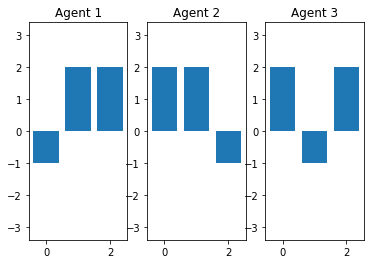

In [10]:
env = Environment(n_agents, n_items, agents) 
env.init_state(state)
#env.init_state(new_s)
env.show()

[]


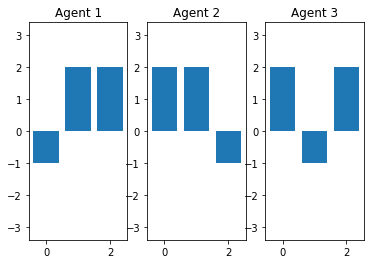

In [11]:
env.show()
print(env.hist_SW)

In [12]:
def episode(env):
    n_agents = env.n_agents
    n_items = env.n_items
    opt_sw = env.optimal_social_welfare()
    print('opt_sw:', opt_sw)
    env.next_round()
    
    env.states_history.append(env.state)
    current_SW = env.global_utility(env.state)
    env.hist_SW.append(current_SW)
    
    for i_A in range(n_agents):
        uti_agent = env.local_utility(env.state, i_A)
        env.hist_ut_agents[i_A].append(uti_agent)
    
    env.show()

        
    
    demands = np.zeros([n_agents, n_items])
    
    
    coop_degrees = np.zeros([n_agents, n_agents])
    
    for i_agent in range(n_agents):
        transa = env.agents[i_agent].offer(env)
        env.agents[i_agent].last_offers.append(transa)
        #print(transa)
        
        print("Agent ",i_agent)
        coop_deg_detected = env.agents[i_agent].coop_detection(env)
        print("coop deg detected ", coop_deg_detected)
        
        coop_deg_i = env.agents[i_agent].negociation(coop_deg_detected)
        print("coop deg negociated ", coop_deg_i)
        print()
        
        
        demands[i_agent, : ] = transa
        coop_degrees[i_agent,:] = coop_deg_i
        
    coop_degrees = np.clip(coop_degrees,0,1)
    
    print('coop_degrees:\n', coop_degrees)
    env.hist_coop_degrees.append(coop_degrees)
    
    print('demands:\n', demands)
    env.allocation(coop_degrees, demands)
    #print(np.sum(env.state, axis=1))

In [13]:
def mean_coop_degrees(matrix_list):
    if matrix_list == []:
        return []
    else:
        (n_A,_) = np.shape(matrix_list[0])
        output = [ [[] for _ in range(n_A)], [[] for _ in range(n_A)] ]  #curves for mean receiving AND sending coop degree 
        for coop_degrees_mat in matrix_list:
            rece_coop = coop_degrees_mat.sum(0)
            send_coop = coop_degrees_mat.sum(1)
            for i_A in range(n_A):
                mean_rece = (rece_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[0][i_A].append(mean_rece)    #receiving coop degree mean for agent i_A

                mean_send = (send_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[1][i_A].append(mean_send)    #receiving coop degree mean for agent i_A

        return output

In [14]:
def figure_utilities(sw, list_ut, output_fig, max_t, lu=2,uu=4):
    colors = ['b','m','c','r']
    t_max = min(len(sw), max_t)
    t = np.arange(t_max)
    
    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize = 14)
    ax1.set_ylabel('Social Welfare', color='g', fontsize = 14)
    ax1.plot(t, sw[:t_max], color='g', label="Social Welfare")
    ax1.tick_params(axis='y', labelcolor='g', labelsize = 14)
    plt.legend(loc=2, fontsize=13)

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Individual Utility', color=color, fontsize = 14) 
    ax2.set_ylim(lu, uu)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 14)
    ax1.tick_params(axis='x', labelsize = 14)



    for i_A in range(len(list_ut)):
        color = colors[i_A]
        label = "Agent "+str(i_A+1)
        if i_A == 5:
            label = "Egoist"
        ax2.plot(t, list_ut[i_A][:t_max], color=color, label=label)
    
    plt.legend(loc=4, fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

In [15]:
def figure_coop_degrees_mean(list_coop, output_fig, max_t, lc=0 ,uc=1):
    colors = ['b','m','c','g','r']
    
    t_max = min(len(list_coop[0][0]), max_t)
    t = np.arange(t_max)

    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize=14)
    ax1.set_ylabel('Mean Cooperation Degree',fontsize=14)

    ax1.set_ylim(lc, uc)

    ax1.tick_params(axis='y', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    


    for i_A in range(len(list_coop[0])):
        color = colors[i_A]
        if i_A != 5:
            label = "Agent "+str(i_A+1)
        else:
            label = "Egoist"
        ax1.plot(t, list_coop[0][i_A][:t_max], color, label = label + " : receiving")
        ax1.plot(t, list_coop[1][i_A][:t_max], color+"--", label = label + " : sending")
        plt.legend(loc=4, fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

In [16]:
def affiche(env, output, lu, uu, lc, uc):
    y_A = env.hist_ut_agents[0]
    y_B = env.hist_ut_agents[1]
    y_C = env.hist_ut_agents[2]
    #y_D = env.hist_ut_agents[3]
    y = env.hist_SW

    y_A = [-x for x in y_A]
    y_B = [-x for x in y_B]
    y_C = [-x for x in y_C]
    #y_D = [-x for x in y_D]
    y = [-x for x in y]
    
    mean_coop_degrees_expe = mean_coop_degrees(env.hist_coop_degrees)
    
    figure_utilities(y, [y_A, y_B, y_C], 'evolution_utilities_'+output +'.svg',10, lu, uu)
    
    figure_coop_degrees_mean(mean_coop_degrees_expe, 'evolution_cooperation_'+output+'.svg',10, lc, uc)    

In [17]:
env = Environment(3, 3, agents)
env.init_state(STATE_E)

In [18]:
def effiency(list_SW, SWopt):
    SW0 = list_SW[0]
    output = []
    
    for sw in list_SW:
        e = min((-sw+SW0)/(-SWopt+SW0), 1)
        output.append(e)
        
    return output

In [19]:
def speed(list_eff, T):
    final_efficiency = list_eff[-1]
    x = np.arange(T)    
    return metrics.auc(x, list_eff[:T])/(T*final_efficiency)

In [20]:
def analyse(state, beta, r, alpha, N_iter=10):
    algo = TFT(beta, r, alpha)
    egoist = TFT(1, 0, 0.5)

    # n_agents: number of actors, n_items: number of items
    n_agents, n_items = np.shape(state)
    
    T_speed = 10    
    T_speed = min(T_speed, N_iter)

    a1 = Agent(0, n_agents, n_items, algo)
    a2 = Agent(1, n_agents, n_items, algo)
    a3 = Agent(2, n_agents, n_items, algo)

    b1 = Agent(0, n_agents, n_items, algo)
    b2 = Agent(1, n_agents, n_items, algo)
    b3 = Agent(2, n_agents, n_items, egoist)
    
    c1 = Agent(0, n_agents, n_items, algo)
    c2 = Agent(1, n_agents, n_items, egoist)
    c3 = Agent(2, n_agents, n_items, egoist)

    agents_A = [a1, a2, a3]
    agents_B = [b1, b2, b3]
    agents_C = [c1, c2, c3]
    
    env_A = Environment(n_agents, n_items, agents_A)
    env_A.init_state(state)
    
    env_B = Environment(n_agents, n_items, agents_B)
    env_B.init_state(state)
    
    env_C = Environment(n_agents, n_items, agents_C)
    env_C.init_state(state)
    
    tra, ns, swopt = env_A.optimize_globally()
    
    for i_ep in range(N_iter):
        print("Env A, episode ", i_ep)
        episode(env_A)
        
    for i_ep in range(N_iter):
        print("Env B, episode ", i_ep)
        episode(env_B)
        
    for i_ep in range(N_iter):
        print("Env C, episode ", i_ep)
        episode(env_C)
            
    effic = effiency(env_A.hist_SW, swopt)
    
    ef = effic[-1]

    sp = speed(effic, T_speed)
    
    ut_max_pers_nices = -1 * env_A.hist_ut_agents[2][-1] #positive
    ut_pers_3egoist = -1 * env_A.hist_ut_agents[0][0] #positive  
    ut_pers_1egoist = -1 * env_B.hist_ut_agents[2][-1] #positive
    ut_pers_2egoist = -1 * env_C.hist_ut_agents[0][-1] #positive

    print(ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist)
    
    ic = (ut_max_pers_nices-ut_pers_1egoist) / ut_max_pers_nices
    sf = (ut_pers_2egoist-ut_pers_3egoist)
    
    return [[beta, r, alpha], [env_A, env_B, env_C], ef, sp, ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist]

state:
 [[-1.  2.  2.]
 [ 2.  2. -1.]
 [ 2. -1.  2.]]
Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.876295360341707
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

coop_degrees:
 [[0.09 0.09 0.09]
 [0.09 0.09 0.09]
 [0.09 0.09 0.09]]
demands:
 [[ 1.92285554 -0.97489182 -0.94796373]
 [-0.97141434 -0.98587887  1.95729318]
 [-0.97701087  1.94695304 -0.96994331]]
agents_demands
 [[1.92285554 0.         0.        ]
 [0.         0.         1.95729318]
 [0.         1.94695304 0.        ]]
agents_offers
 [[-0.          0.9748918

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.        0.        0.0007138]
coop deg negociated  [0.18971081 0.1        0.19029061]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1.         0.25088125 0.        ]
coop deg negociated  [0.99980684 0.39296853 0.1       ]

coop_degrees:
 [[0.1        0.65577133 0.19050013]
 [0.18971081 0.1        0.19029061]
 [0.99980684 0.39296853 0.1       ]]
demands:
 [[ 0.01675523 -0.00539078 -0.01136451]
 [-0.00305282 -0.01676496  0.01981594]
 [ 0.00072057  0.00963053 -0.01035195]]
agents_demands
 [[0.01675523 0.         0.        ]
 [0.         0.         0.01981594]
 [0.00072057 0.00963053 0.        ]]
agents_offers
 [[-0.          0.00539078  0.01136451]
 [ 0.00305282  0.01676496 -0.        ]
 [-0.         -0.          0.01035195]]
Env A, episode  8
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.886829045655157
Stopping search: Swarm be

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.85529678321958
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.        0.3434411 0.       ]
coop deg negociated  [0.0999999  0.41057606 0.0999999 ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.38362027 0.         0.        ]
coop deg negociated  [0.44306946 0.0999999  0.0999999 ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10800491 0.11497748 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.0999999  0.41057606 0.0999999 ]
 [0.44306946 0.0999999  0.0999999 ]
 [0.         0.         0.        ]]
demands:
 [[ 0.95611087 -0.68865443 -0.26745788]
 [-0.2742516  -0.66949338  0.94374498]
 [-0.6970883   1.36581986 -0.66873162]]
agents_demands
 [[0.95611087 0.         0.        ]
 [0.         0.         0.94374498]
 [0.         1.36581986 0.        ]]
agents_offers
 [[-0.

/home/xavier/sharing_resources/sharing_resources/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.09 0.09 0.09]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.94020755 -0.96349341 -0.97671418]
 [-0.94688508 -1.01514004  1.96202508]
 [-1.05897363  1.91268421 -0.85371068]]
agents_demands
 [[1.94020755 0.         0.        ]
 [0.         0.         1.96202508]
 [0.         1.91268421 0.        ]]
agents_offers
 [[-0.          0.96349341  0.97671418]
 [ 0.94688508  1.01514004 -0.        ]
 [ 1.05897363 -0.          0.85371068]]
Env C, episode  1
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.878926932930476
Stopping search: Swarm best objec

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.82412960075575
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.1 0.1 0.1]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.10551906 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10506229 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.1 0.1 0.1]
 [0.  0.  0. ]
 [0.  0.  0. ]]
demands:
 [[ 1.4560808  -0.69256873 -0.76351208]
 [-0.76965092 -0.70234293  1.47199384]
 [-0.71693662  1.44686086 -0.72992436]]
agents_demands
 [[1.4560808  0.         0.        ]
 [0.         0.         1.47199384]
 [0.         1.44686086 0.        ]]
agents_offers
 [[-0.          0.69256873  0.76351208]
 [ 0.76965092  0.70234293 -0.        ]
 [ 0.71693662 -0.          0.72992436]]
Env C, episode  

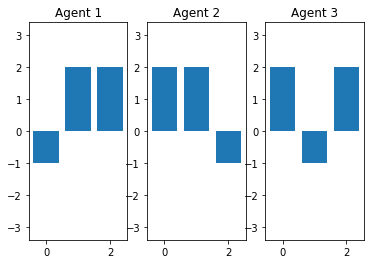

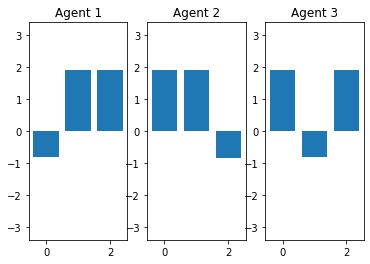

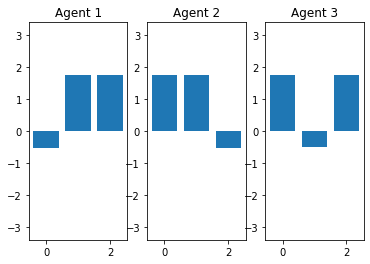

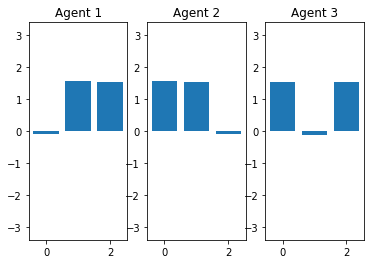

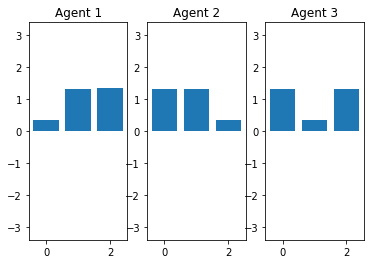

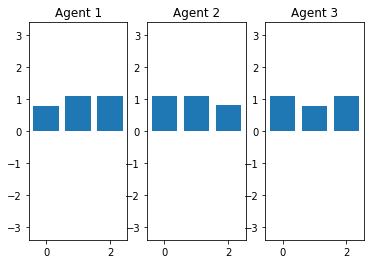

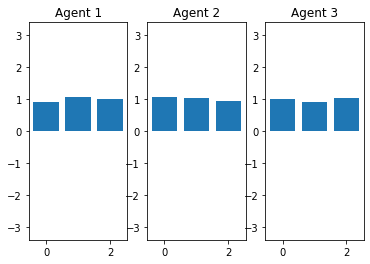

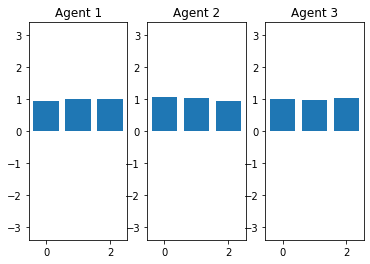

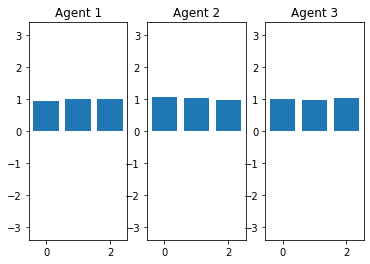

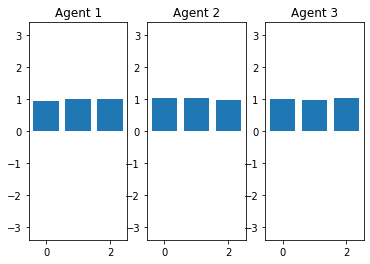

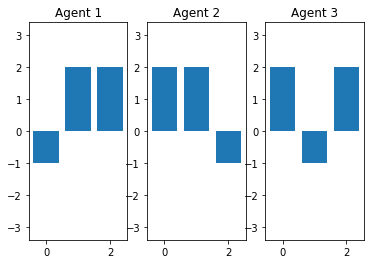

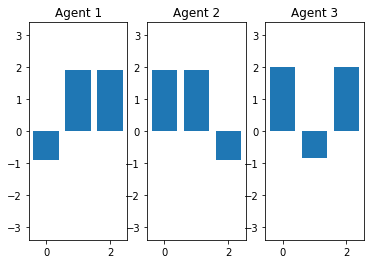

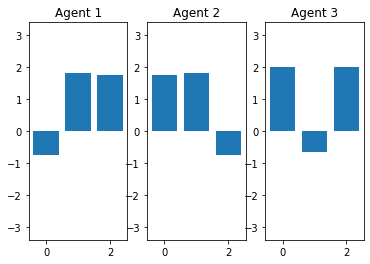

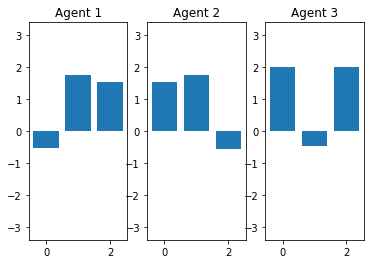

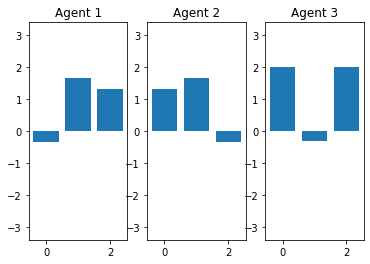

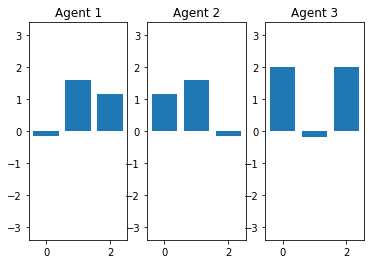

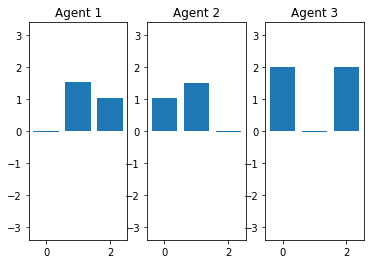

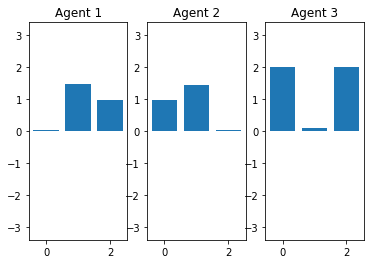

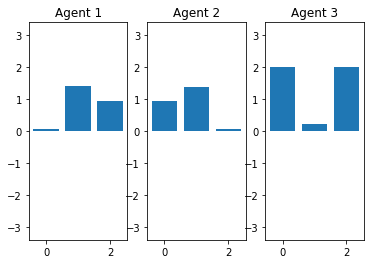

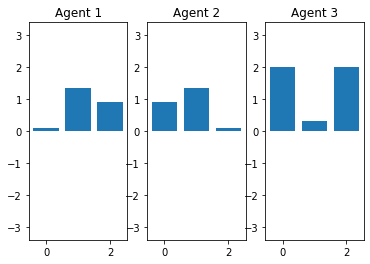

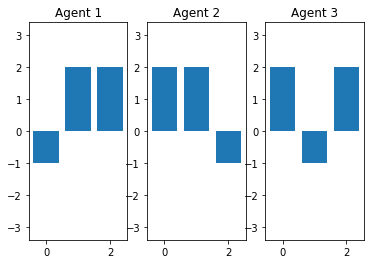

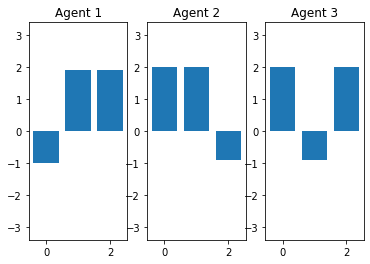

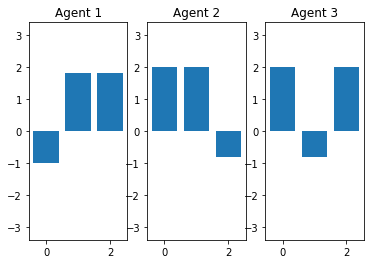

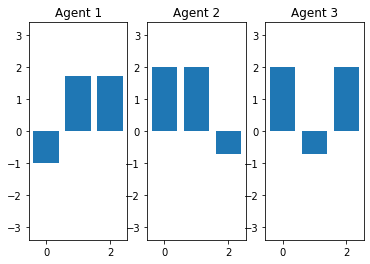

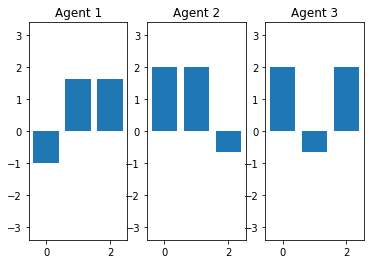

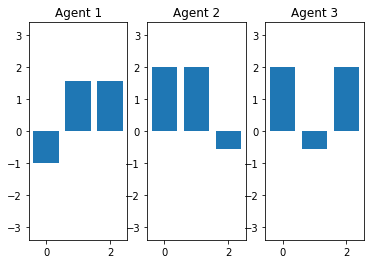

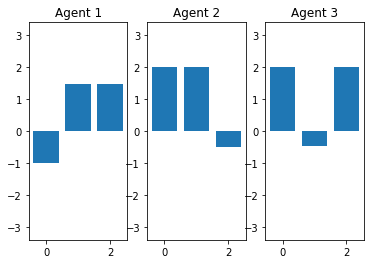

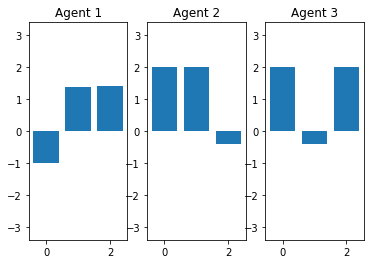

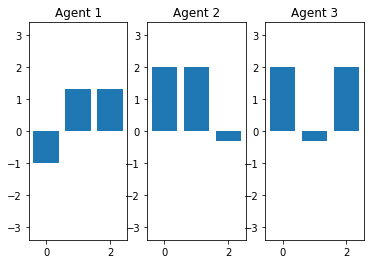

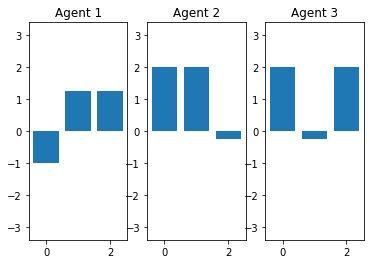

In [21]:
beta = 0.1
r = 0.1
alpha = 0
n_iter = 10
state = STATE_E
print('state:\n', state)
result = analyse(state, beta, r, alpha, n_iter)

In [22]:
env_D = result[1][0]
env_E = result[1][1]
env_F = result[1][2]

ut_max_pers_nices = -1 * env_D.hist_ut_agents[2][-1] #positive
ut_pers_3egoist = -1 * env_D.hist_ut_agents[0][0] #positive  
ut_pers_1egoist = -1 * env_E.hist_ut_agents[2][-1] #positive
ut_pers_2egoist = -1 * env_F.hist_ut_agents[0][-1] #positive

ic = ut_max_pers_nices-ut_pers_1egoist
sf = ut_pers_2egoist - ut_pers_3egoist

print(ic, sf)

print(ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist)

-0.31902341429109393 -0.41701848303456224
3.2955765732005746 3.6145999874916686 2.355570254205219 2.772588737239781


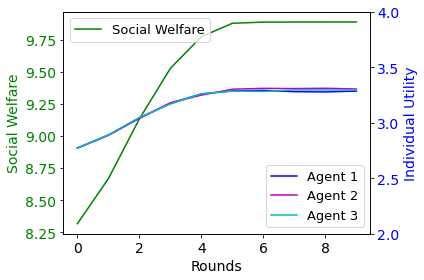

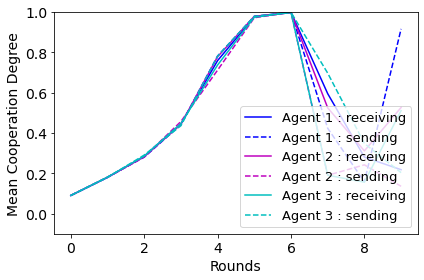

In [23]:
affiche(env_D, 'One_egoist', 2, 4, -0.1, 1)

In [28]:
def do_experiments(experiments):
    output = []
    for experiment in experiments:
        beta, r, alpha = experiment
        N_iter = 15
        a = analyse(STATE_E, beta, r, alpha, N_iter)
        output.append(a)
    
    return output

In [29]:
experiments = [
    # beta, r, alpha
    (0.1, 0.05, 0), 
    (0.1, 0.02, 0)
]

experiments_2 = [
    # beta, r, alpha
    (0.1, 0.05, 0),
    (0.1, 0.02, 0),
    (0.3, 0.1, 0),
    (0.5, 0.1, 0),
    (0.7, 0.1, 0),
    (0.1, 0.1, 0.3),
    (0.1, 0.1, 0.5),
    (0.1, 0.1, 0.7)
]

Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.87389321131044
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

coop_degrees:
 [[0.045 0.045 0.045]
 [0.045 0.045 0.045]
 [0.045 0.045 0.045]]
demands:
 [[ 1.93094426 -0.96605363 -0.96489064]
 [-0.96314268 -0.95811948  1.92126214]
 [-0.96745964  1.97022062 -1.00276118]]
agents_demands
 [[1.93094426 0.         0.        ]
 [0.         0.         1.92126214]
 [0.         1.97022062 0.        ]]
agents_offers
 [[-0.          0.96605363  0.96489064]
 [ 0.96314268  0.95811

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [0.96884404 0.05       0.96216538]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1. 1. 0.]
coop deg negociated  [0.95859041 0.96386017 0.05      ]

coop_degrees:
 [[0.05       0.96044756 0.96213215]
 [0.96884404 0.05       0.96216538]
 [0.95859041 0.96386017 0.05      ]]
demands:
 [[ 0.19353461 -0.11330466 -0.08022999]
 [-0.09333231 -0.08034091  0.17367313]
 [-0.10993638  0.17584448 -0.06590846]]
agents_demands
 [[0.19353461 0.         0.        ]
 [0.         0.         0.17367313]
 [0.         0.17584448 0.        ]]
agents_offers
 [[-0.          0.11330466  0.08022999]
 [ 0.09333231  0.08034091 -0.        ]
 [ 0.10993638 -0.          0.06590846]]
Env A, episode  8
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.887012004457368
Stopping search: Swarm best objective change less than 1e-08
Agent  0


Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.70337434 0.         0.        ]
coop deg negociated  [0.70060578 0.05637029 0.05      ]

coop_degrees:
 [[0.05       0.45638646 0.9999145 ]
 [0.07401937 0.05       0.05342948]
 [0.70060578 0.05637029 0.05      ]]
demands:
 [[ 0.00274295 -0.00300029  0.000257  ]
 [-0.00335162 -0.00222752  0.00557904]
 [-0.00163416  0.00146096  0.00017316]]
agents_demands
 [[0.00274295 0.         0.000257  ]
 [0.         0.         0.00557904]
 [0.         0.00146096 0.00017316]]
agents_offers
 [[-0.          0.00300029 -0.        ]
 [ 0.00335162  0.00222752 -0.        ]
 [ 0.00163416 -0.         -0.        ]]
Env B, episode  0
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.883302555205272
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08


/home/xavier/sharing_resources/sharing_resources/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.21327888 0.        ]
coop deg negociated  [0.04999995 0.2488249  0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.20548756 0.         0.        ]
coop deg negociated  [0.24263536 0.04999995 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05122665 0.05217398 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.04999995 0.2488249  0.04999995]
 [0.24263536 0.04999995 0.04999995]
 [0.         0.         0.        ]]
demands:
 [[ 1.31876791 -0.79299737 -0.52577111]
 [-0.56254275 -0.77002271  1.33256537]
 [-0.82778569  1.64250226 -0.81471896]]
agents_demands
 [[1.31876791 0.         0.        ]
 [0.         0.         1.33256537]
 [0.         1.64250226 0.        ]]
agents_offers
 [[-0.          0.79299737  0.52577111]
 [ 0.56254275  0.77002271 -0.        ]
 [ 0.827785

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05167301 0.0531042  0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.05       0.09533303 0.05      ]
 [0.10022762 0.05       0.05      ]
 [0.         0.         0.        ]]
demands:
 [[ 0.80516262 -0.62760742 -0.17755525]
 [-0.15481529 -0.64449381  0.79930818]
 [-0.62100009  1.25470999 -0.63370995]]
agents_demands
 [[0.80516262 0.         0.        ]
 [0.         0.         0.79930818]
 [0.         1.25470999 0.        ]]
agents_offers
 [[-0.          0.62760742  0.17755525]
 [ 0.15481529  0.64449381 -0.        ]
 [ 0.62100009 -0.          0.63370995]]
Env B, episode  13
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.847017239432653
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.03968197 0.        ]
coop deg negociated  [0.05       0.08846139 0.05      ]

Stopping search: Swarm best objective change 

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.04999995 0.04999995 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.0495505 0.        0.       ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05439798 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.04999995 0.04999995 0.04999995]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
demands:
 [[ 1.80245238 -0.89132593 -0.91112655]
 [-0.96698355 -0.81297597  1.77995912]
 [-0.88432569  1.72210766 -0.83778208]]
agents_demands
 [[1.80245238 0.         0.        ]
 [0.         0.         1.77995912]
 [0.         1.72210766 0.        ]]
agents_offers
 [[-0.          0.89132593  0.91112655]
 [ 0.96698355  0.81297597 -0.        ]
 [ 0.88432569 -0.          0.83778208]]
Env C, episode  6
Stop

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.05250227 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05023477 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.05 0.05 0.05]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.54600971 -0.76789525 -0.77811936]
 [-0.76275353 -0.77155274  1.53430617]
 [-0.77489317  1.55968792 -0.78479477]]
agents_demands
 [[1.54600971 0.         0.        ]
 [0.         0.         1.53430617]
 [0.         1.55968792 0.        ]]
agents_offers
 [[-0.          0.76789525  0.77811936]
 [ 0.76275353  0.77155274 -0.        ]
 [ 0.77489317 -0.          0.78479477]]
Env C, episode  14
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.8298699915929
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.0

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.872330980662884
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.13635472 0.13851594]
coop deg negociated  [0.02       0.15022894 0.15233344]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.12882298 0.         0.13446362]
coop deg negociated  [0.14346505 0.02       0.14853231]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.14218434 0.14297391 0.        ]
coop deg negociated  [0.1552655  0.15660618 0.02      ]

coop_degrees:
 [[0.02       0.15022894 0.15233344]
 [0.14346505 0.02       0.14853231]
 [0.1552655  0.15660618 0.02      ]]
demands:
 [[ 1.27638575 -0.62091879 -0.65546702]
 [-0.66496174 -0.63503867  1.30000025]
 [-0.63855286  1.26024687 -0.62169407]]
agents_demands
 [[1.27638575 0.         0.        ]
 [0.         0.         1.30000025]
 [0.         1.26024687 0.   

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [0.99925668 0.02       0.99881334]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1. 1. 0.]
coop deg negociated  [0.99948398 0.99946009 0.02      ]

coop_degrees:
 [[0.02       0.99721544 0.11607173]
 [0.99925668 0.02       0.99881334]
 [0.99948398 0.99946009 0.02      ]]
demands:
 [[ 0.03059394 -0.02023377 -0.01036017]
 [-0.00403651 -0.00699654  0.01103303]
 [-0.0068001   0.0050724   0.00172769]]
agents_demands
 [[0.03059394 0.         0.        ]
 [0.         0.         0.01103303]
 [0.         0.0050724  0.00172769]]
agents_offers
 [[-0.          0.02023377  0.01036017]
 [ 0.00403651  0.00699654 -0.        ]
 [ 0.0068001  -0.         -0.        ]]
Env A, episode  14
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.88665927040495
Stopping search: Swarm best objective change less than 1e-08
Agent  0


Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.871654363900994
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.09653212 0.        ]
coop deg negociated  [0.02       0.11369843 0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.1026158 0.        0.       ]
coop deg negociated  [0.11886157 0.02       0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.02020312 0.02087285 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02       0.11369843 0.02      ]
 [0.11886157 0.02       0.02      ]
 [0.         0.         0.        ]]
demands:
 [[ 1.57610591 -0.89697698 -0.679129  ]
 [-0.69253172 -0.889493    1.58202428]
 [-0.92033589  1.78554797 -0.86521212]]
agents_demands
 [[1.57610591 0.         0.        ]
 [0.         0.         1.58202428]
 [0.         1.78554797 0.        ]]
agents_offers
 [[-0

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01982177 0.02081073 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02       0.0728196  0.02      ]
 [0.07297527 0.02       0.02      ]
 [0.         0.         0.        ]]
demands:
 [[ 1.14666977 -0.80424364 -0.34242615]
 [-0.32428958 -0.80137508  1.1256645 ]
 [-0.81534834  1.63658659 -0.82123827]]
agents_demands
 [[1.14666977 0.         0.        ]
 [0.         0.         1.1256645 ]
 [0.         1.63658659 0.        ]]
agents_offers
 [[-0.          0.80424364  0.34242615]
 [ 0.32428958  0.80137508 -0.        ]
 [ 0.81534834 -0.          0.82123827]]
Env B, episode  14
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.8685490432954
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.04290573 0.        ]
coop deg negociated  [0.02       0.06312481 0.02      ]

Stopping search: Swarm best objective change le

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.02 0.02 0.02]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.02028071 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01987019 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02 0.02 0.02]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.8584028  -0.91844803 -0.93995519]
 [-0.9020825  -0.9285298   1.8306121 ]
 [-0.92484387  1.85312307 -0.9282792 ]]
agents_demands
 [[1.8584028  0.         0.        ]
 [0.         0.         1.8306121 ]
 [0.         1.85312307 0.        ]]
agents_offers
 [[-0.          0.91844803  0.93995519]
 [ 0.9020825   0.9285298  -0.        ]
 [ 0.92484387 -0.          0.9282792 ]]
Env C, episode  7
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.8

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.02048955 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.02056329 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02 0.02 0.02]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.73501269 -0.85559211 -0.87942068]
 [-0.93004916 -0.78183296  1.71188167]
 [-0.87891992  1.74443355 -0.86551368]]
agents_demands
 [[1.73501269 0.         0.        ]
 [0.         0.         1.71188167]
 [0.         1.74443355 0.        ]]
agents_offers
 [[-0.          0.85559211  0.87942068]
 [ 0.93004916  0.78183296 -0.        ]
 [ 0.87891992 -0.          0.86551368]]
3.301305045640636 3.172203262226116 2.6397938303096873 2.772588737239781
 

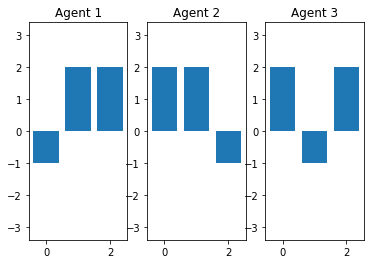

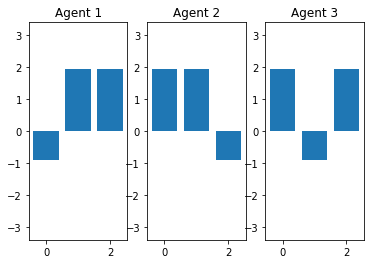

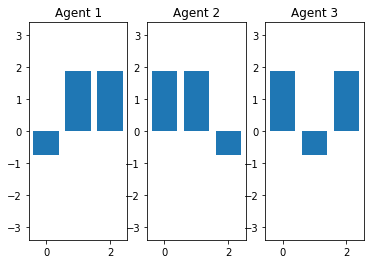

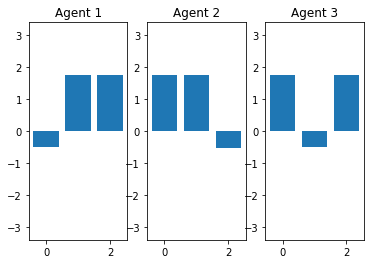

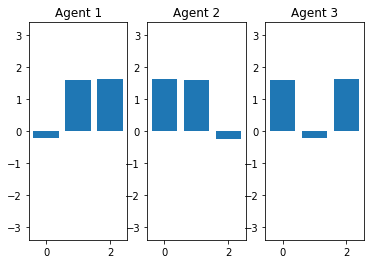

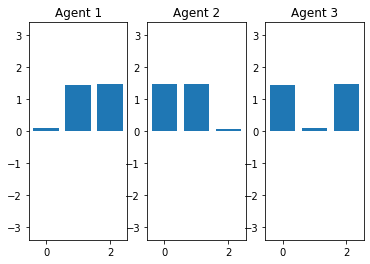

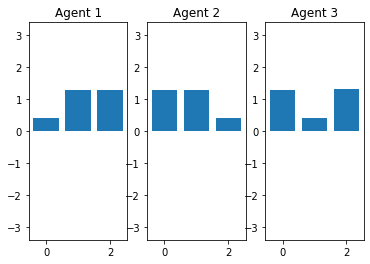

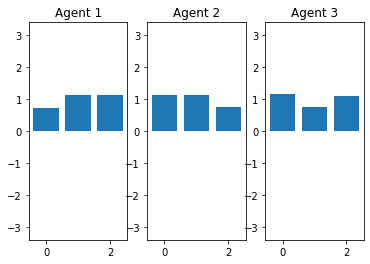

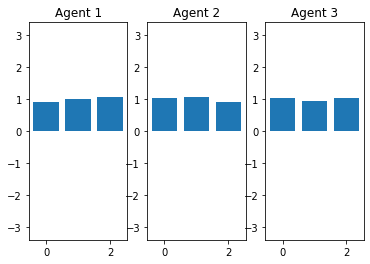

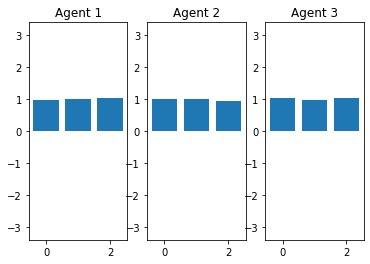

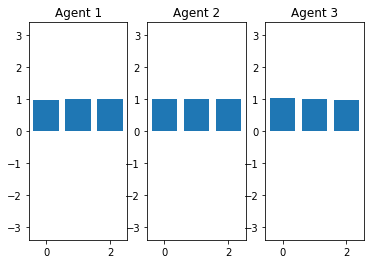

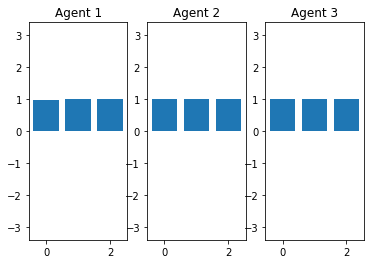

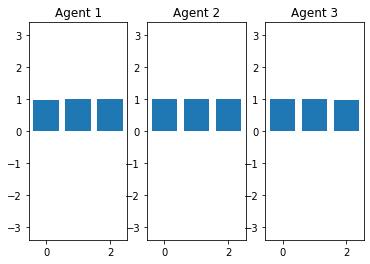

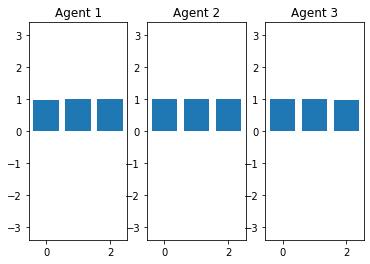

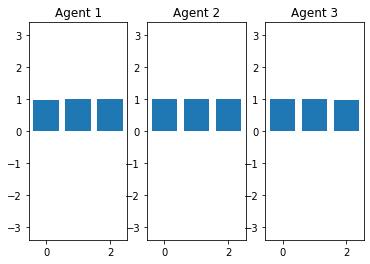

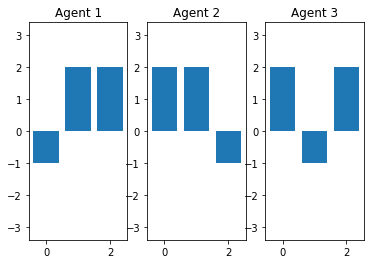

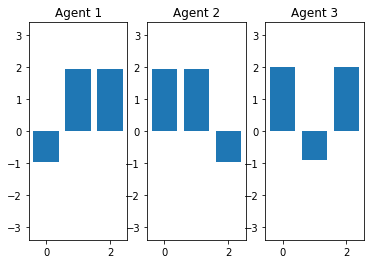

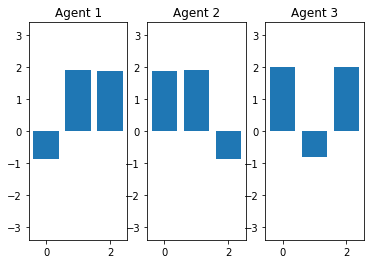

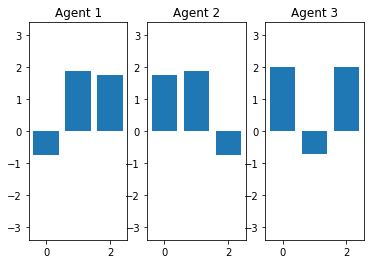

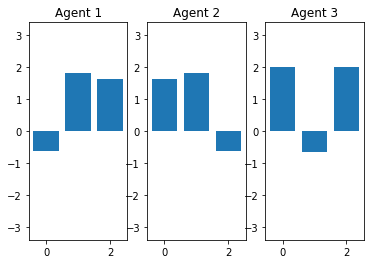

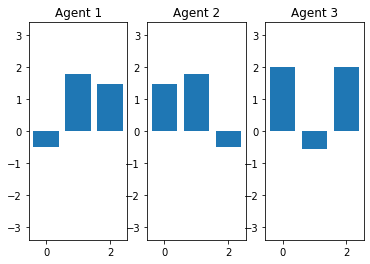

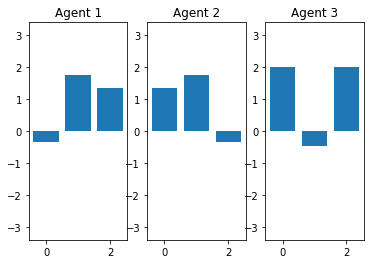

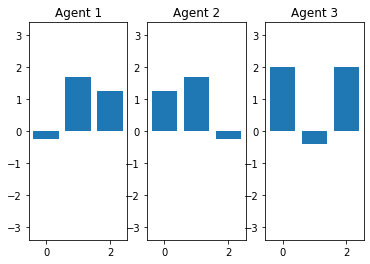

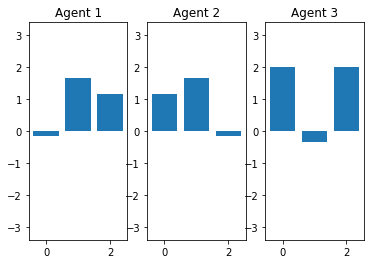

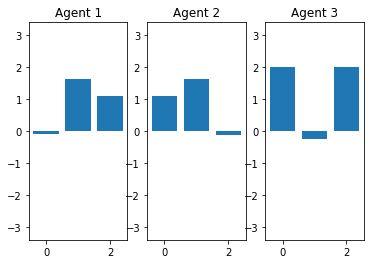

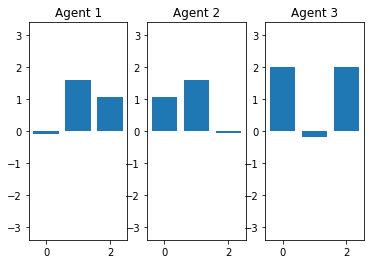

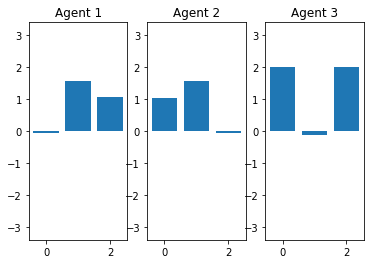

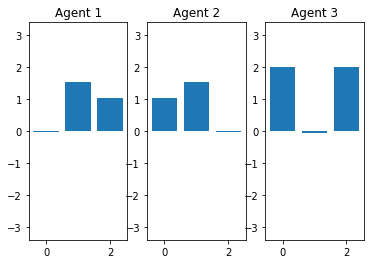

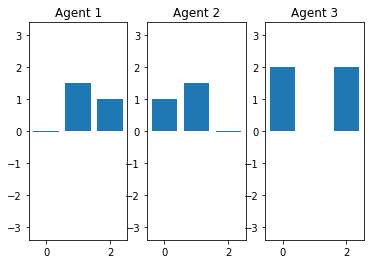

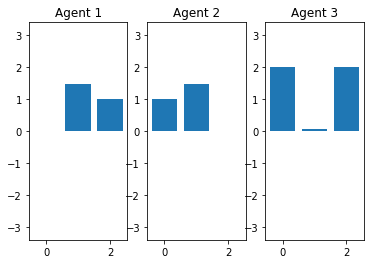

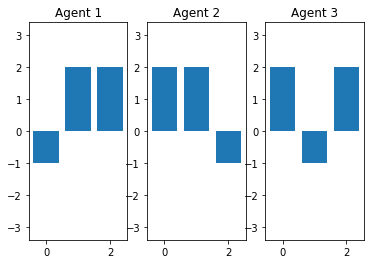

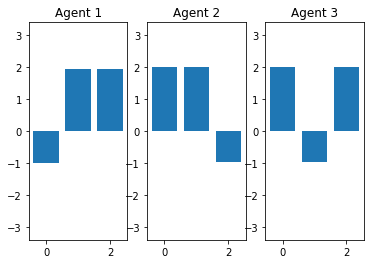

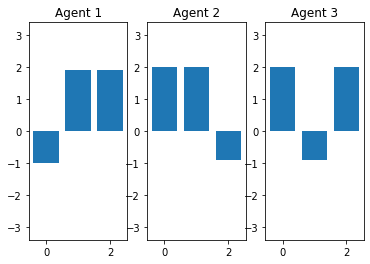

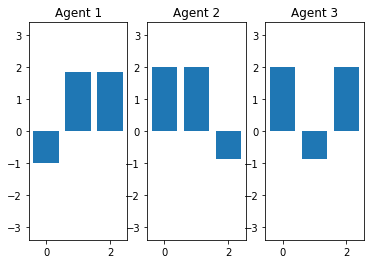

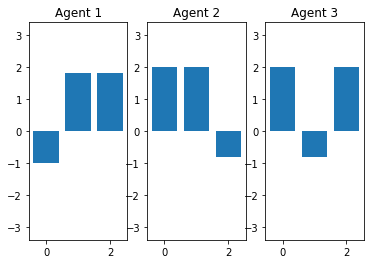

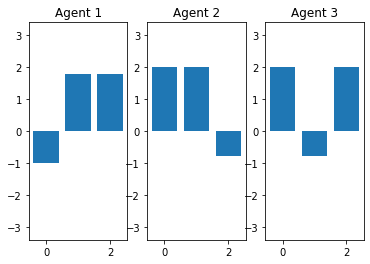

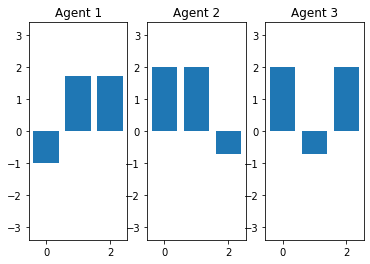

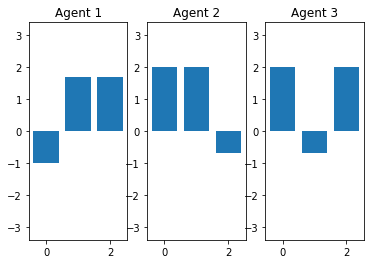

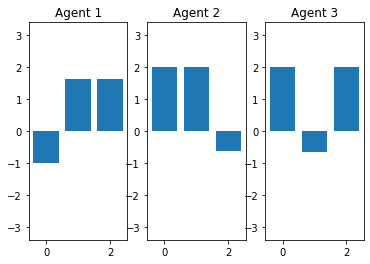

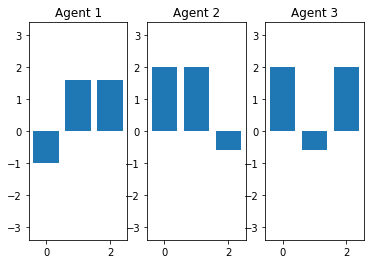

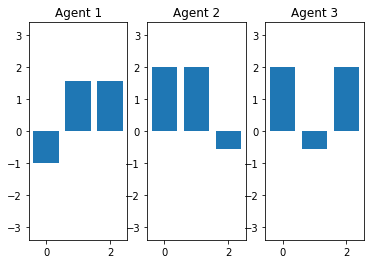

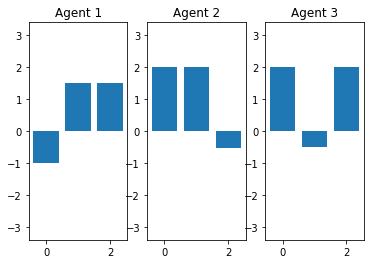

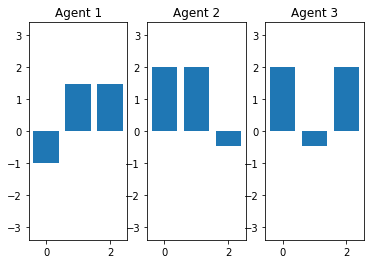

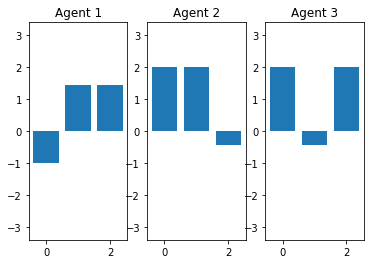

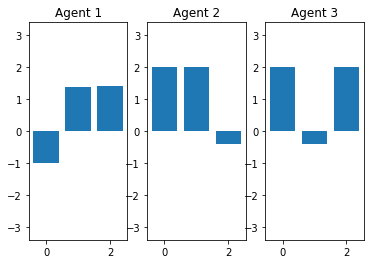

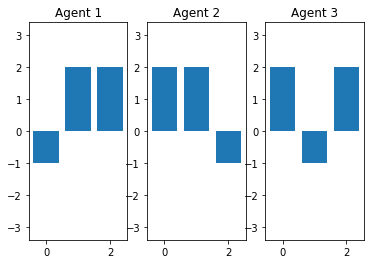

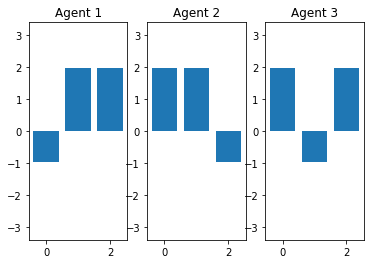

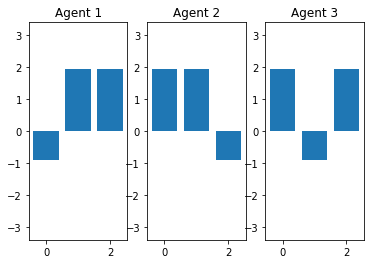

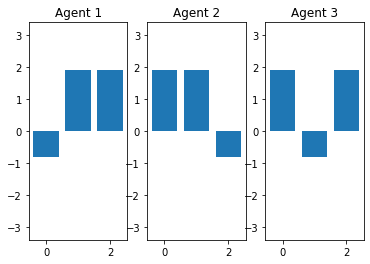

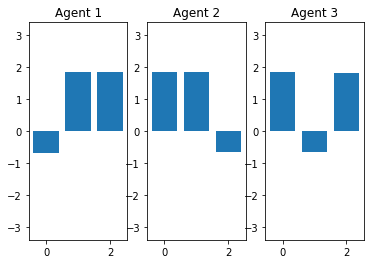

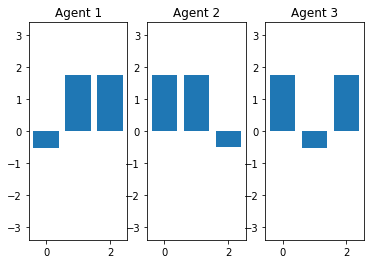

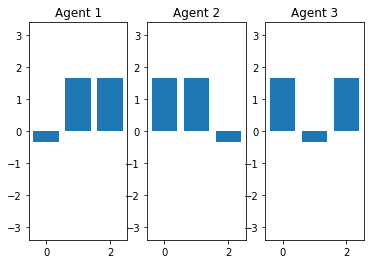

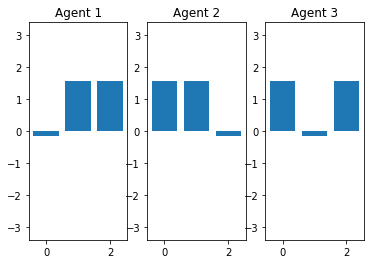

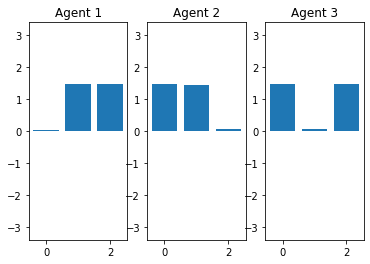

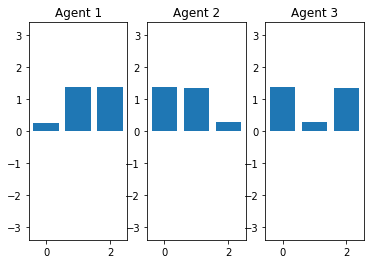

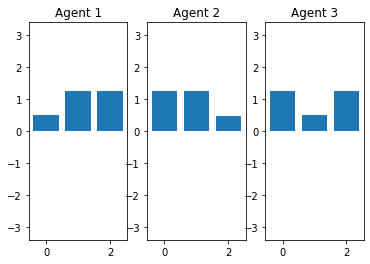

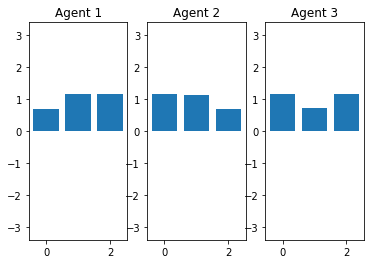

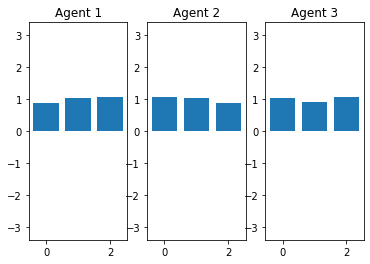

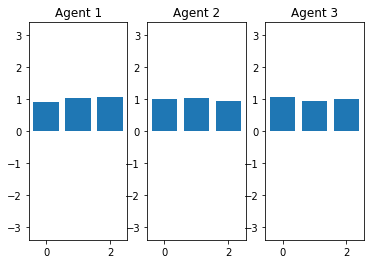

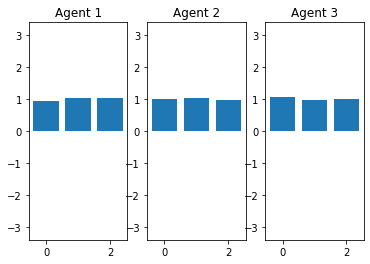

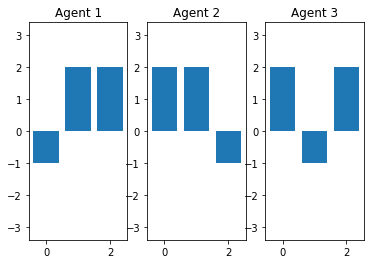

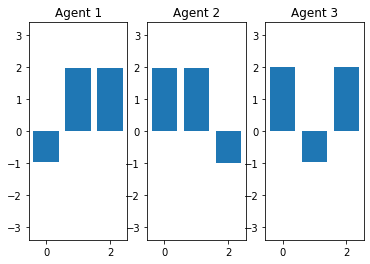

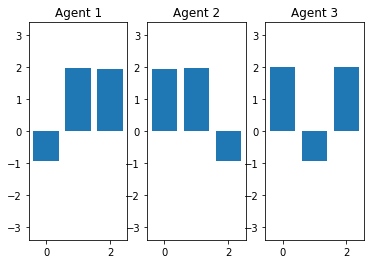

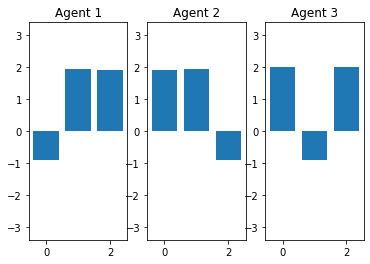

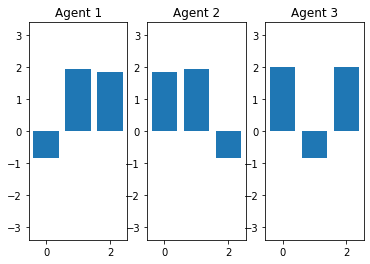

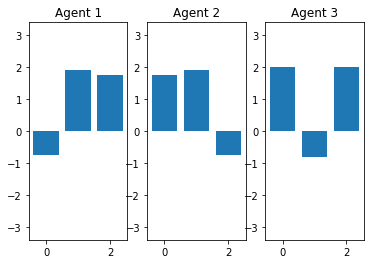

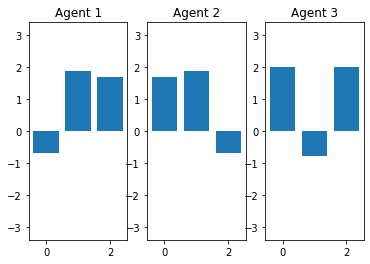

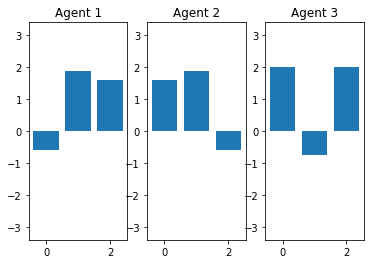

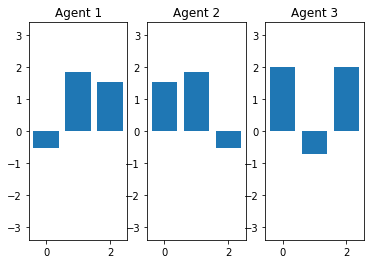

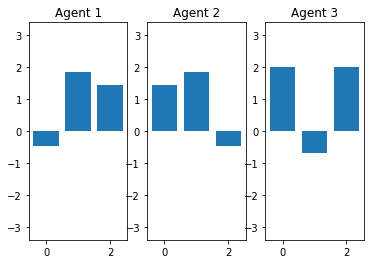

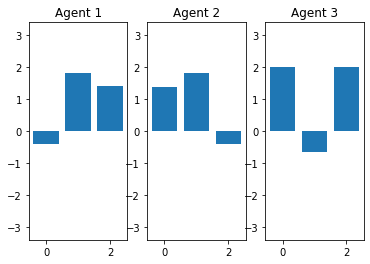

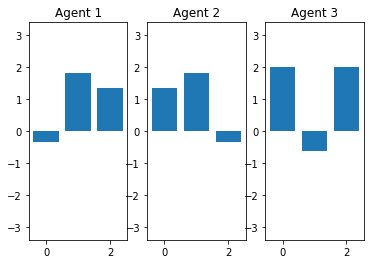

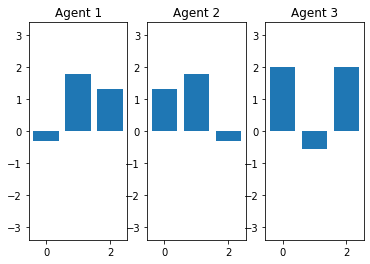

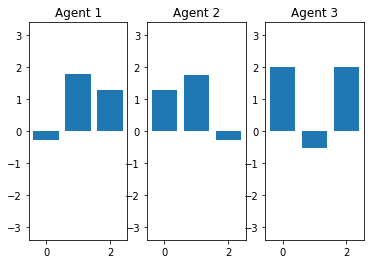

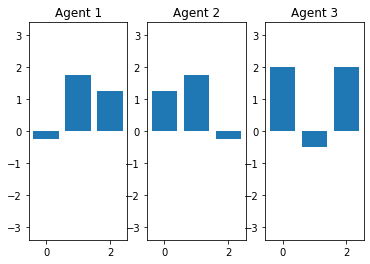

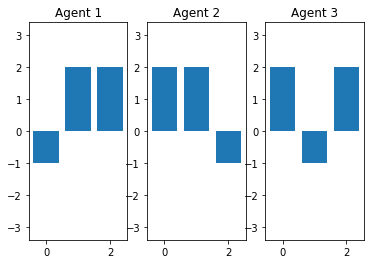

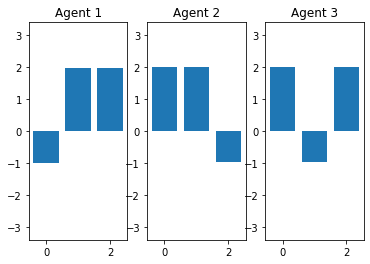

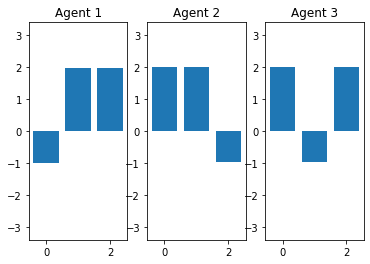

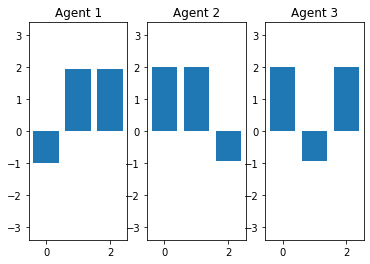

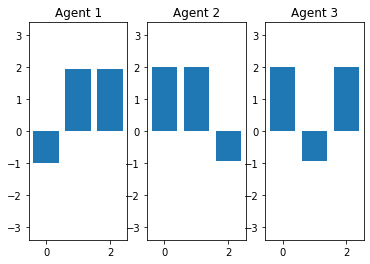

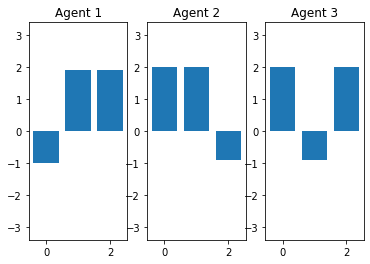

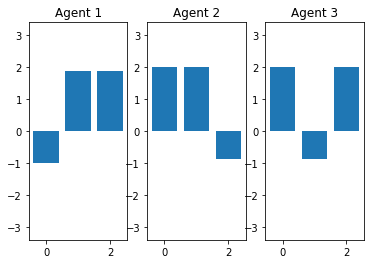

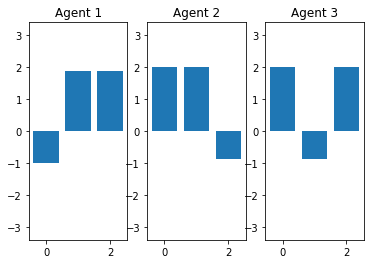

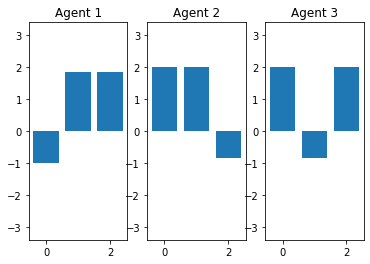

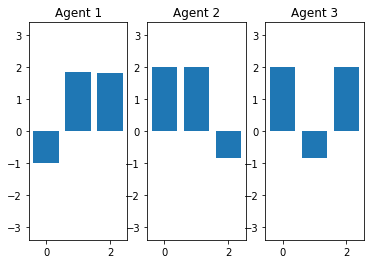

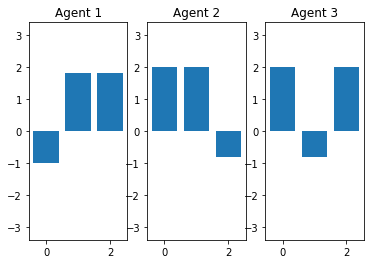

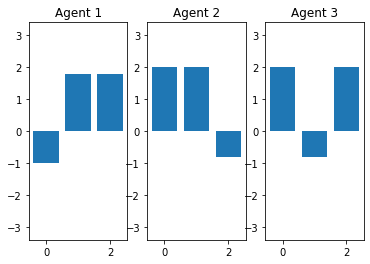

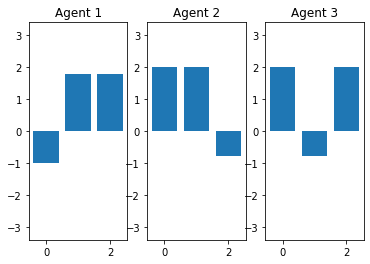

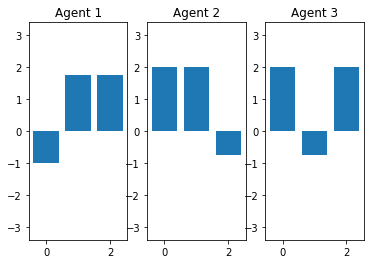

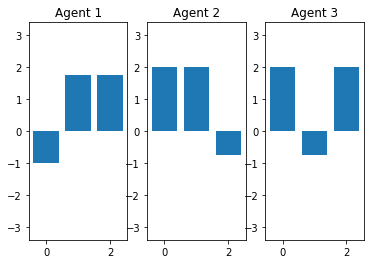

In [30]:
output = do_experiments(experiments)

In [31]:
for x in output:
    param, _, e, sp, utN, ut1E, ut2E, ut3E = x
    print(param, e, sp, ut1E, ut2E)

[0.1, 0.05, 0] 1 0.5959161082111025 3.503148540211201 2.44462687450263
[0.1, 0.02, 0] 1 0.4054002081308396 3.172203262226116 2.6397938303096873
